# Report for the Deep Learning Course
This is a template notebook of your report. Please complete your report with your teammate following these instructions:
- **Rename your notebook** in the format `FirstName1FAMILYNAME1_FirstName2FAMILYNAME2_report2.ipynb`. For example, when the team consists of Johann FAOUZI and Ikko YAMANE, the file name should look like `JohannFAOUZI_IkkoYAMANE_report2.ipynb`.
- Answer in English.
- Please submit your notebook on Moodle.
- The submission deadline is 18:00 (UTC+2) of December 15, 2024.


**Remarks**:
- The accuracy of your models is not important for the evaluation, but I expect the performance is at least better than a random guess or a constant predictor.
- I encourage you to explain your problem setups/code/algorithms/archtectures/methods/tools/results with Python comments or Markdown text. You can use figures, plots, or other visualization techniques. The quality of explanations will be great part of the evaluation.
- Needless to say, do not copy solutions from other students.
- If your code is based on any articles, code examples, or web pages, **clearly mention the references and how you used them**.
- Likewise, if you use AI tools, clearly explain how you used them and which parts of your answers were given by the AIs, and make sure that you check and understand those parts yourself.
- If I detect any work copied from anywhere else without acknowledging it, your grade will get a **significant penalty**.

## Question 0
Enter your information below.
- Name of Author 1: COMBY Killian
- Name of Author 2: DELMARE Bastien
- Email address of Author 1: killian.comby@eleve.ensai.fr
- Email address of Author 2: bastien.delmare@eleve.ensai.fr

## Question 1 (Noun-Verb Classification)

Train two different classifiers for the Noun-Verb dataset [1], which we have seen in the ateliers, and compare their performance.

---
**References**

[1] Ali Elkahky and Kellie Webster and Daniel Andor and Emily Pitler. A Challenge Set and Methods for Noun-Verb Ambiguity, In *Proceedings of EMNLP*, 2018.

Importation de la table : 

In [2]:
def load_dataset(path='data'):
    """Load the noun verb dataset.

    Parameters
    ----------
    path : str
        Path to the directory.

    Returns
    -------
    train : Conll
        Training set.

    validation : Conll
        Validation set.

    test : Conll
        Test set.

    """
    import os
    import pyconll
    from urllib.request import urlretrieve

    if not os.path.exists(path):
        os.makedirs(path)
    
    files = ('train.conll', 'dev.conll', 'test.conll')

    # Downloads the files if necessary
    for file in files:
        if not os.path.isfile(os.path.join(path, file)):
            url = f'https://raw.githubusercontent.com/google-research-datasets/noun-verb/master/{file}'
            urlretrieve(url, os.path.join(path, file))

    return (pyconll.load_from_file(os.path.join(path, file)) for file in files)

On compare un CNN et un LSTM pour classifier : 


Entraînement du modèle CNN
Epoch 5/15:
Train Loss: 0.3610, Test Loss: 0.6543
Epoch 10/15:
Train Loss: 0.1569, Test Loss: 0.9765
Epoch 15/15:
Train Loss: 0.1108, Test Loss: 1.1908

Entraînement du modèle LSTM
Epoch 5/15:
Train Loss: 0.4386, Test Loss: 0.6997
Epoch 10/15:
Train Loss: 0.2291, Test Loss: 0.8708
Epoch 15/15:
Train Loss: 0.1480, Test Loss: 1.0784


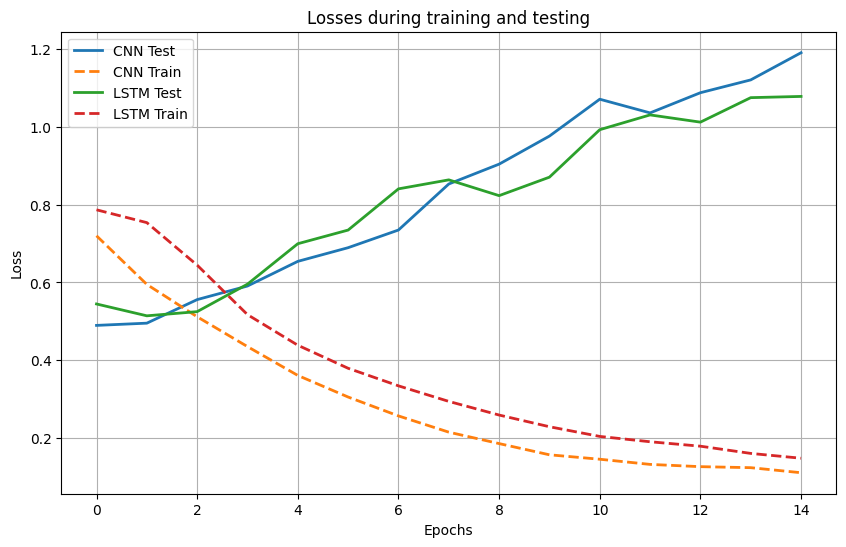

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

class ConllDataset(Dataset):
    def __init__(self, conll_data, max_len=50):
        self.sentences = []
        self.labels = []
        self.max_len = max_len
        
        word_counter = Counter()
        label_counter = Counter()
        
        for sentence in conll_data:
            words = [token.form.lower() for token in sentence]
            words = words[:max_len]
            label = sentence[0].upos if len(sentence) > 0 else 'NONE'
            
            word_counter.update(words)
            label_counter.update([label])
            
            self.sentences.append(words)
            self.labels.append(label)
        
        self.word2idx = {word: idx+1 for idx, (word, _) in enumerate(word_counter.most_common())}
        self.word2idx['<PAD>'] = 0
        self.label2idx = {label: idx for idx, (label, _) in enumerate(label_counter.most_common())}
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        
        sentence_indices = [self.word2idx.get(word, 0) for word in sentence]
        if len(sentence_indices) < self.max_len:
            sentence_indices = sentence_indices + [0] * (self.max_len - len(sentence_indices))
        
        return torch.tensor(sentence_indices), torch.tensor(self.label2idx[label])

# Implémentation personnalisée d'une cellule LSTM
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Portes : input, forget, output, et cellule candidate
        self.Wih = nn.Linear(input_size, 4 * hidden_size)
        self.Whh = nn.Linear(hidden_size, 4 * hidden_size)
        
    def forward(self, input, state):
        h_prev, c_prev = state
        gates = self.Wih(input) + self.Whh(h_prev)
        
        # Séparer les différentes portes
        i_gate, f_gate, o_gate, g_gate = gates.chunk(4, dim=1)
        
        # Appliquer les fonctions d'activation
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        o_gate = torch.sigmoid(o_gate)
        g_gate = torch.tanh(g_gate)
        
        # Mettre à jour la cellule
        c_next = f_gate * c_prev + i_gate * g_gate
        h_next = o_gate * torch.tanh(c_next)
        
        return h_next, c_next

# Implémentation personnalisée du LSTM complet
class CustomLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_classes, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_cell = LSTMCell(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, n_classes)
        self.dropout = nn.Dropout(dropout)
        self.hidden_dim = hidden_dim
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_length = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        c = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        
        embedded = self.embedding(x)
        
        for t in range(seq_length):
            h, c = self.lstm_cell(embedded[:, t, :], (h, c))
        
        output = self.dropout(h)
        return self.fc(output)

# Implémentation personnalisée du CNN
class CustomCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, n_classes, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Implémentation manuelle des convolutions 1D
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(embedding_dim, n_filters, kernel_size=k) 
            for k in [3, 4, 5]
        ])
        
        self.fc = nn.Linear(len(self.conv_layers) * n_filters, n_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)  # Changement de dimension pour conv1d
        
        # Application des convolutions et max pooling
        conv_outputs = []
        for conv in self.conv_layers:
            conv_out = torch.relu(conv(embedded))
            pooled = torch.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)
            conv_outputs.append(pooled)
        
        # Concaténation et classification
        concatenated = torch.cat(conv_outputs, dim=1)
        dropped = self.dropout(concatenated)
        return self.fc(dropped)

def train_and_plot_with_test(train_loader, test_loader, device, n_epochs=15):
    models = {
        'CNN': CustomCNN(
            vocab_size=len(train_loader.dataset.word2idx),
            embedding_dim=100,
            n_filters=100,
            n_classes=len(train_loader.dataset.label2idx),
            dropout=0.5
        ),
        'LSTM': CustomLSTM(
            vocab_size=len(train_loader.dataset.word2idx),
            embedding_dim=100,
            hidden_dim=256,
            n_classes=len(train_loader.dataset.label2idx),
            dropout=0.5
        )
    }
    
    # Dictionnaires pour stocker les historiques
    histories = {name: {'train_loss': [], 'test_loss': []} for name in models.keys()}
    
    for name, model in models.items():
        print(f"\nEntraînement du modèle {name}")
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
        
        for epoch in range(n_epochs):
            # Entraînement
            model.train()
            train_loss = 0
            for text, labels in train_loader:
                text, labels = text.to(device), labels.to(device)
                optimizer.zero_grad()
                predictions = model(text)
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            train_loss = train_loss / len(train_loader)
            
            # Test
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for text, labels in test_loader:
                    text, labels = text.to(device), labels.to(device)
                    predictions = model(text)
                    loss = criterion(predictions, labels)
                    test_loss += loss.item()
            
            test_loss = test_loss / len(test_loader)
            
            # Enregistrement des pertes
            histories[name]['train_loss'].append(train_loss)
            histories[name]['test_loss'].append(test_loss)
            
            if (epoch + 1) % 5 == 0:
                print(f'Epoch {epoch+1}/{n_epochs}:')
                print(f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    # Création du graphique
    plt.figure(figsize=(10, 6))
    for name in models.keys():
        plt.plot(histories[name]['test_loss'], label=f'{name} Test', linestyle='-', linewidth=2)
        plt.plot(histories[name]['train_loss'], label=f'{name} Train', linestyle='--', linewidth=2)
    
    plt.title('Losses during training and testing')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    return plt.gcf()


def main_with_test():
    train_data, _, test_data = load_dataset()
    
    train_dataset = ConllDataset(train_data, max_len=50)
    test_dataset = ConllDataset(test_data, max_len=50)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Entraînement et création du graphique
    plt_figure = train_and_plot_with_test(train_loader, test_loader, device, n_epochs=15)
    
    return plt_figure


if __name__ == '__main__':
    main_with_test()


## Question 2 (Food Image Classification)

By adapting the LeNet-5 [3], train a simple classifier for a resized version of the [Food-7 dataset](https://huggingface.co/datasets/cv-talks/food-7) dataset, which is a subset of the Food-101 dataset [2].

Execute the following five code cells to load the dataset.

---
**References**

[2] Bossard, Lukas; Guillaumin, Matthieu; Van Gool, Luc. Food-101 -- Mining Discriminative Components with Random Forests,
_European Conference on Computer Vision_, 2014.
URL: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/.


[3] Lecun, Yann; Bottou, Léon; Bengio, Yoshua; Haffner, Patrick. "Gradient-based learning applied to document recognition" (PDF). _Proceedings of the IEEE_. 86 (11): 2278–2324, 1998.

In [1]:
!pip install datasets[vision]
!pip install gdown

zsh:1: no matches found: datasets[vision]


In [2]:
import os
import gdown
import zipfile
from datasets import load_from_disk


def download_food7(path='data/food'):
    filename = 'food7_34x34.zip'
    gdriveid = '1eZFfl8MUSN_WeovPkxR0_R7DS7TzQrxk'

    if not os.path.exists(path):
        os.makedirs(path)

    filepath = os.path.join(path, filename)
    if not os.path.isfile(filepath):
        gdown.download(id=gdriveid, output=filepath, quiet=False)


def load_food7(path='data/food'):
    filename = 'food7_34x34.zip'
    filepath = os.path.join(path, filename)
    with zipfile.ZipFile(filepath, 'r') as f:
        f.extractall(path)

    ds = load_from_disk(path)
    label_names = ds.features['label'].names
    class2name = {i: label_names[i] for i in range(len(label_names))}

    return ds, class2name


download_food7()
ds_food7, class2name = load_food7()

/home/ensai/Documents/ENSAI/3A/Deep learning/DM_deep/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Split the dataset to train (size 6000) and test (size 1000) splits.

from torch.utils.data import random_split

train_size = 6000
test_size = 1000

ds_food7_split = ds_food7.train_test_split(
    train_size=train_size,
    test_size=test_size,
    stratify_by_column='label'
)

In [5]:
# Prepare dataloaders.

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as tvtf

def collate_fn1(minibatch):
    """ Transform each minibatch.
    """
    images = []
    labels = []
    for example in minibatch:
        images.append(example["image"])
        labels.append(example["label"])

    return torch.tensor(images), torch.tensor(labels)

dataloader_train = DataLoader(ds_food7_split['train'], collate_fn=collate_fn1, batch_size=32)
dataloader_test = DataLoader(ds_food7_split['test'], collate_fn=collate_fn1, batch_size=128)

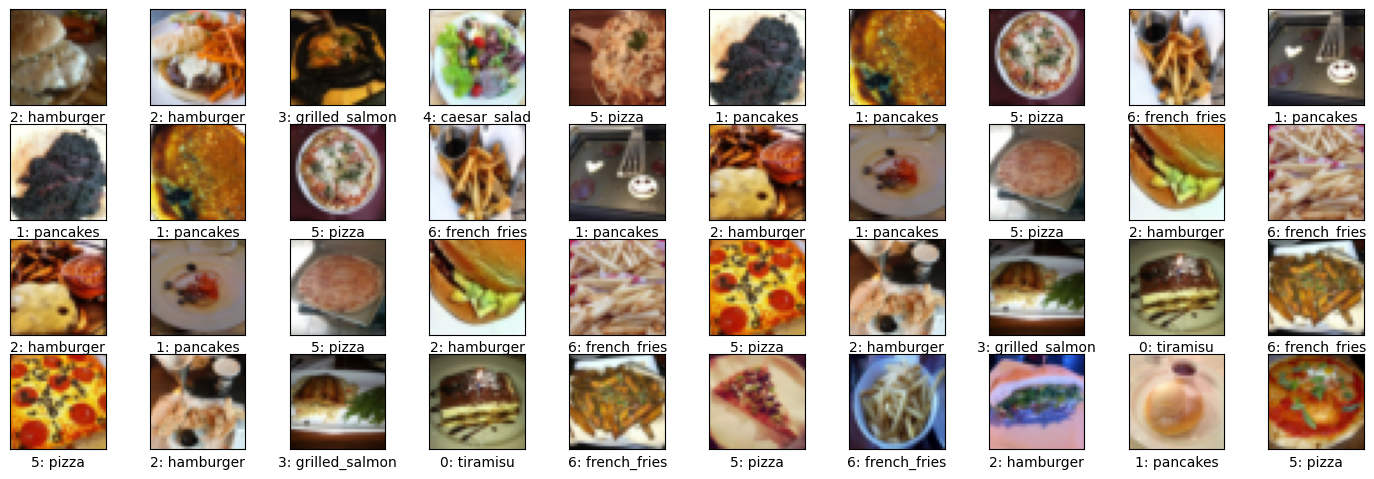

In [7]:
# Show example images.

import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_example_images(dataset):
    nrow = 4
    ncol = 10
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 4))

    X, y = next(iter(DataLoader(
            ds_food7,
            collate_fn=collate_fn1,
            batch_size=nrow * ncol,
            shuffle=True)))

    for i in range(nrow):
        for j in range(ncol):
            # img = minibatch['image'][5*i + j]
            # label = minibatch['label'][5*i + j]
            img = X[5*i + j]
            label = y[5*i + j]
            ax[i][j].imshow(np.transpose(img, [1, 2, 0]))
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel(f'{label.item()}: {class2name[label.item()]}')

    fig.subplots_adjust(bottom=0.1, right=1.5, top=1.2)

show_example_images(dataset=ds_food7)

### How to use the Food-7 dataset

After executing the previous five cells, you will get the following objects.

- `dataloader_train`: `torch.data.util.Dataloader` object holding the training split of the dataset. The size is 6000.

- `dataloader_test`: `torch.data.util.Dataloader` object holding the test split of the dataset. The size is 1000.

- `class2name`: Python dictionary to map a numerically represented class to its name. For example, `class2name[0] == 'tiramisu'`.

- `ds_food7`: the Hugging Face `datasets.Dataset` object storing the whole dataset.

Each image has 3 channels and is of size $34 \times 34$. There are 7 classes. See the last code cell to learn how to use the dataloader.

## Question 3 (Small Project)
Find a dataset that has not appeared in the course and apply any method that we have learned (or any deep learning method that you have discovered yourself).


Nous nous concentrons sur la base de données MNIST et cherchons à mettre en place un réseau de Koopeman : 

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 852kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 308kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.76MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.19MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/30], Loss: 0.1512
Epoch [2/30], Loss: 0.0730
Epoch [3/30], Loss: 0.0576
Epoch [4/30], Loss: 0.0492
Epoch [5/30], Loss: 0.0445


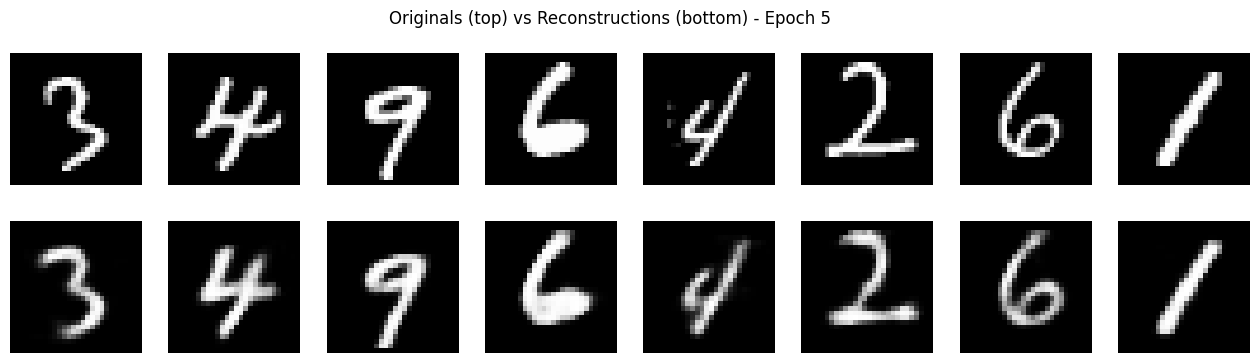

Epoch [6/30], Loss: 0.0413
Epoch [7/30], Loss: 0.0386
Epoch [8/30], Loss: 0.0363
Epoch [9/30], Loss: 0.0348
Epoch [10/30], Loss: 0.0338


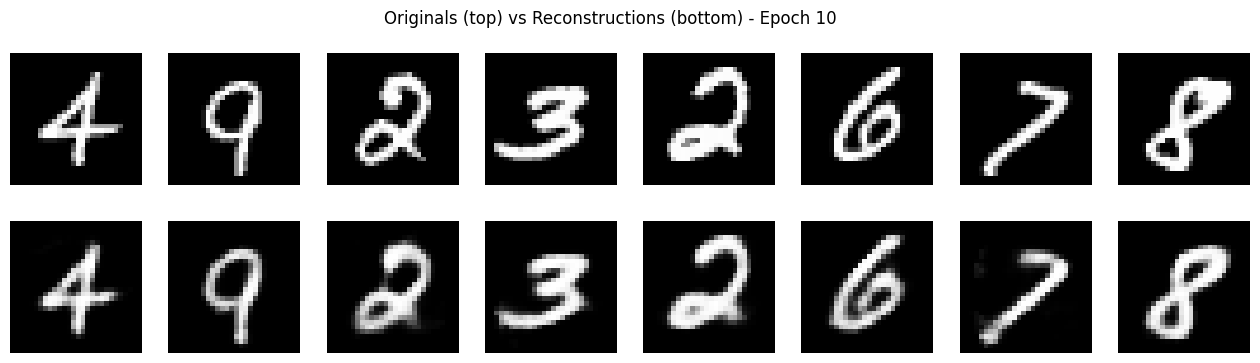

Epoch [11/30], Loss: 0.0325
Epoch [12/30], Loss: 0.0318
Epoch [13/30], Loss: 0.0311
Epoch [14/30], Loss: 0.0307
Epoch [15/30], Loss: 0.0302


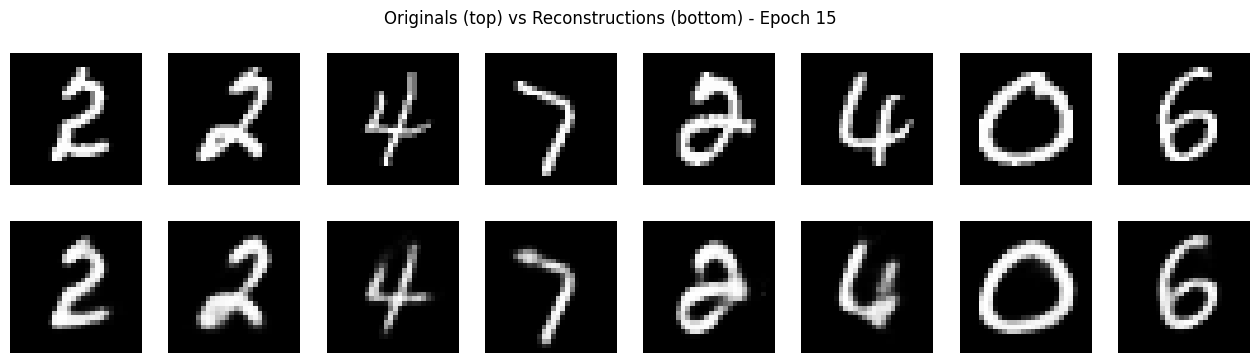

Epoch [16/30], Loss: 0.0296
Epoch [17/30], Loss: 0.0289
Epoch [18/30], Loss: 0.0286
Epoch [19/30], Loss: 0.0282
Epoch [20/30], Loss: 0.0279


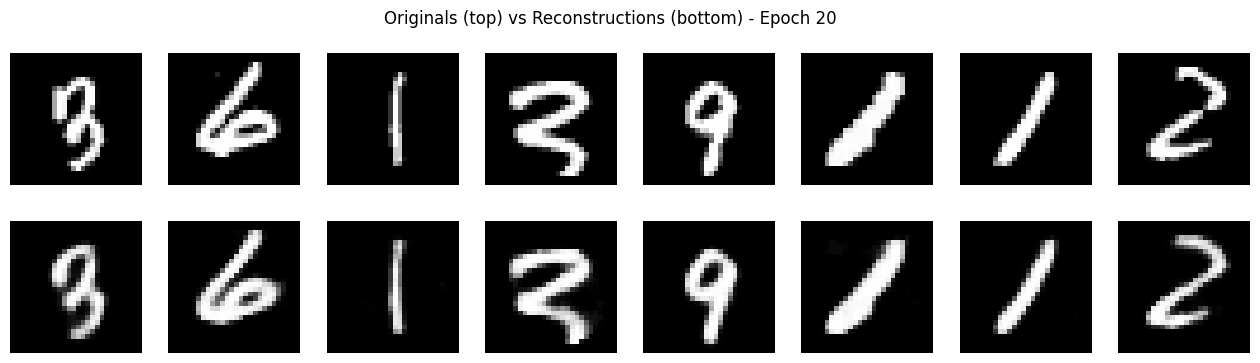

Epoch [21/30], Loss: 0.0277
Epoch [22/30], Loss: 0.0274
Epoch [23/30], Loss: 0.0271
Epoch [24/30], Loss: 0.0268
Epoch [25/30], Loss: 0.0265


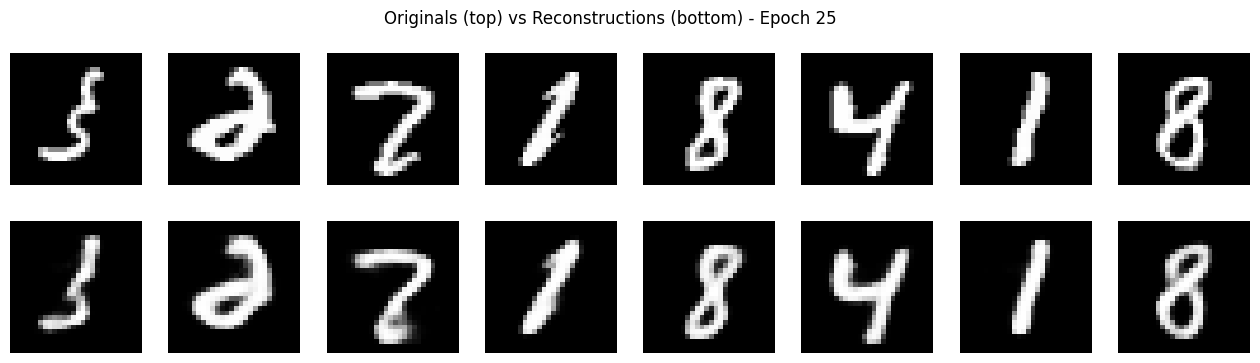

Epoch [26/30], Loss: 0.0262
Epoch [27/30], Loss: 0.0261
Epoch [28/30], Loss: 0.0259
Epoch [29/30], Loss: 0.0258
Epoch [30/30], Loss: 0.0257


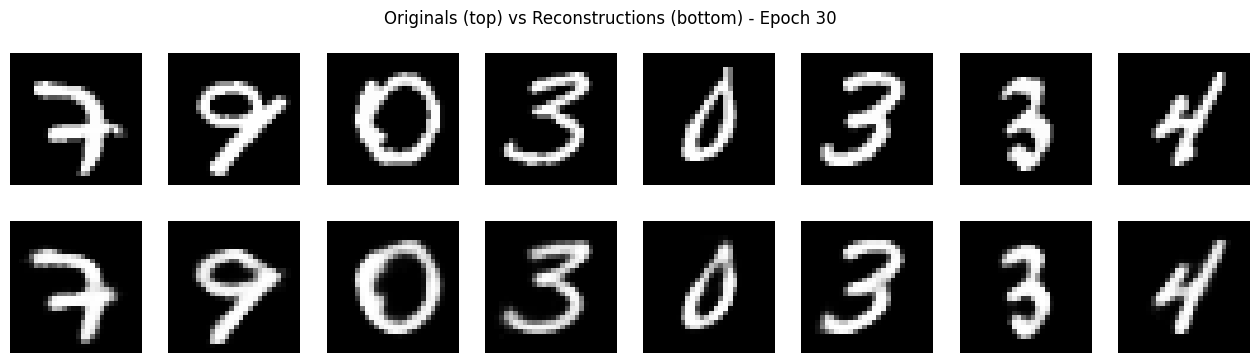

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparamètres
latent_dim = 64
batch_size = 64
n_epochs = 30
learning_rate = 0.001
image_size = 28 * 28  # MNIST images are 28x28
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Préparation des données MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Définition du Réseau de Koopman
class KoopmanNetwork(nn.Module):
    def __init__(self, image_size, latent_dim):
        super(KoopmanNetwork, self).__init__()
        
        # Encodeur : Projection vers l'espace latent
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        
        # Matrice Koopman (transformation linéaire dans l'espace latent)
        self.koopman_matrix = nn.Linear(latent_dim, latent_dim, bias=False)
        
        # Décodeur : Reconstruction de l'image depuis l'espace latent
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Tanh()  # Normalisation entre -1 et 1
        )
        
    def forward(self, x):
        # Encoder
        latent = self.encoder(x)
        
        # Koopman projection
        latent_next = self.koopman_matrix(latent)
        
        # Decode
        reconstructed = self.decoder(latent_next)
        return latent, latent_next, reconstructed

# Initialisation du modèle
model = KoopmanNetwork(image_size, latent_dim).to(device)

# Fonction de perte et optimiseur
criterion = nn.MSELoss()  # On cherche à reconstruire les images
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement du modèle
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1).to(device)  # Convertir en vecteurs
        optimizer.zero_grad()
        
        # Passer les données dans le modèle
        latent, latent_next, reconstructed = model(imgs)
        
        # Calcul des pertes
        loss_reconstruction = criterion(reconstructed, imgs)
        loss_latent_dynamics = criterion(latent_next, latent)  # Latent doit rester proche (Koopman)
        loss = loss_reconstruction + loss_latent_dynamics
        
        # Rétropropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(dataloader):.4f}")

    # Visualisation tous les 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            z, _, reconstructed = model(imgs[:8].to(device))
            fig, axes = plt.subplots(2, 8, figsize=(16, 4))
            for i in range(8):
                # Image originale
                axes[0, i].imshow(imgs[i].cpu().view(28, 28), cmap='gray')
                axes[0, i].axis('off')
                
                # Reconstruction
                axes[1, i].imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
                axes[1, i].axis('off')
            plt.suptitle(f"Originals (top) vs Reconstructions (bottom) - Epoch {epoch + 1}")
            plt.show()
